In [1]:
import sys
sys.path.insert(0, '../../stock_factor_lab/')

# 台股 - 看不同本益比頻率resample

In [2]:
START_DATE = '2003-01-01'
END_DATE = '2009-03-31'

## import

In [3]:
from get_data import Data
import backtest
from combinations import sim_conditions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# import plotly.graph_objs as go
import plotly.express as px
from itertools import cycle
from plotly.subplots import make_subplots
from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Microsoft JhengHei']
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates
from datetime import datetime

# from dataframe import CustomDataFrame

import plot_data

## get data

In [4]:
data=Data()

---

## 一些有的沒的畫圖 function

---

## 資料下載

### **盈餘再投資率**

In [5]:
profit = data.get('annual_report_fundamentals:常續性稅後淨利')

In [6]:
# 抓資料
long_term_items = [
    '透過損益按公允價值衡量之金融資產－非流動',
    '透過其他綜合損益按公允價值衡量之金融資產－非流動',
    '按攤銷後成本衡量之金融資產－非流動',
    '避險之金融資產－非流動',
    '合約資產－非流動',
    '採權益法之長期股權投資',
    '預付投資款',
    '投資性不動產淨額'
]

# 長期投資項目 (8個)
long_term_data = [data.get(f'annual_report_fundamentals:{item}').fillna(0) for item in long_term_items]
long_term_investment = sum(long_term_data)
# 固定資產
fixed_assets_year = data.get('annual_report_fundamentals:不動產廠房及設備').fillna(0)

In [7]:
# 計算盈再率分子
long_term_investment_df = long_term_investment - long_term_investment.shift(4)
fixed_assets_df = fixed_assets_year - fixed_assets_year.shift(4)

In [8]:
profit_rol_df = profit.rolling(4).sum()

In [9]:
# 計算出盈再率
# 去掉淨利為負的公司 (當年度淨利為負、四年加總淨利為負都去掉)
rr = (long_term_investment_df + fixed_assets_df) / profit_rol_df
rr = rr[(profit > 0) & (profit_rol_df > 0)]

---

### **本益比 (P/E)**
- 每季資料
- 每日資料

In [10]:
pe = data.get('quarter_report:PE')
daily_pe = data.get('price:daily_pe')

### **其他因子**

- ROE (季資料，取第四季)
- 股利支付率 (只有年資料) ＝〈現金股利總額〈元〉／ 股利分配年度之稅後淨利〉x 100
- 董監持股 (沒有每年的資料，缺值採向前補值)
- 上市上櫃滿兩年

In [11]:
roe = data.get('annual_report:ROE')
payout_ratio = data.get('annual_report_fundamentals:股利支付率')

In [12]:
stock_hold = data.get('annual_report_fundamentals:董監持股%')

In [13]:
# listed_date = pd.read_csv('../2024_code/最近上市日.csv', encoding='cp950')

##### 上市上櫃滿兩年

In [14]:
close = data.get('price:close')
comp_profile = data.get('company_profile')



stock_data = {}

for index, row in comp_profile.iterrows():
    stock_code = row['company_symbol']
    listed_date_ = row['ipo_date']
    end_date = listed_date_ + pd.DateOffset(years=2)
    
    # 創建一個全為 True 的 series
    series = pd.Series(True, index=close.index)
    # 在上市日之前和之後兩年內設置為 False
    series.loc[:end_date] = False
    
    stock_data[stock_code] = series

listed = pd.concat(stock_data, axis=1)

In [15]:
comp_profile

company_symbol name   ipo_date industry
0              1101   台泥 1962-02-09     水泥工業
1              1102   亞泥 1962-06-18     水泥工業
2              1103   嘉泥 1969-11-27     水泥工業
3              1104   環泥 1971-02-02     水泥工業
4              1108   幸福 1990-06-06     水泥工業
...             ...  ...        ...      ...
1843           9951   皇田 2003-12-18     電機機械
1844           9955   佳龍 2008-01-21     綠能環保
1845           9958  世紀鋼 2008-03-12     鋼鐵工業
1846           9960  邁達康 2004-12-06     運動休閒
1847           9962   有益 2006-07-10     鋼鐵工業

[1848 rows x 4 columns]

---

## 選股條件
- ROE 五年平均 > 15%
- 盈再率 < 80%
- 稅後淨利 > 五億
- 配息 > 40%
- 董監持股 > 10%
- 上市上櫃滿兩年
- PE < 12買入，>30賣出

In [16]:
# ROE 5年平均 > 15%
roe_rol = roe.rolling(5).mean()
roe_15 = (roe_rol > 15)[START_DATE:END_DATE]

In [17]:
rr_cond = (rr < 0.4)[START_DATE:END_DATE]

In [18]:
# *最近3年的配息率有無一年不及40%*
payout_ratio_cond = (payout_ratio.rolling(3).min() >= 40)[START_DATE:END_DATE]

# # 金融股看配息率，不看盈再率
# rr_cond[finance_stock_list] = payout_ratio_cond[finance_stock_list]

In [19]:
# 淨利 > 5億
profit_cond = (profit > 500000)[START_DATE:END_DATE] # TEJ 的淨利單位是千元

In [20]:
# 單位：百分比
hold_cond = stock_hold[START_DATE:END_DATE] > 10

In [21]:
listed = listed.resample('M').last()[START_DATE:END_DATE]

---

## 原始條件 + 無本益比進出場條件

In [22]:
orig_all_cond = roe_15 & rr_cond & payout_ratio_cond & profit_cond & hold_cond & listed

## 原始條件 + 有本益比進出場

### 每季本益比進出場

In [23]:
# (每季)本益比條件

pe_cond_entry = (pe < 12)[START_DATE:END_DATE]
pe_cond_exit = (pe > 30)[START_DATE:END_DATE]

In [24]:
orig_all_cond_and_pe = ((orig_all_cond & pe_cond_entry).hold_until((~orig_all_cond) | pe_cond_exit))

In [25]:
rep_all_cond_and_pe = backtest.sim(orig_all_cond_and_pe, resample='M', data=data)
rep_all_cond_and_pe.get_stats()

{'CAGR': 0.09662694373369773,
 'daily_sharpe': 52.19,
 'max_drawdown': -0.5629055197171287,
 'avg_drawdown': -0.0899355318436352,
 'win_ratio': 0.5151515151515151,
 'ytd': 0.23851206173152129}

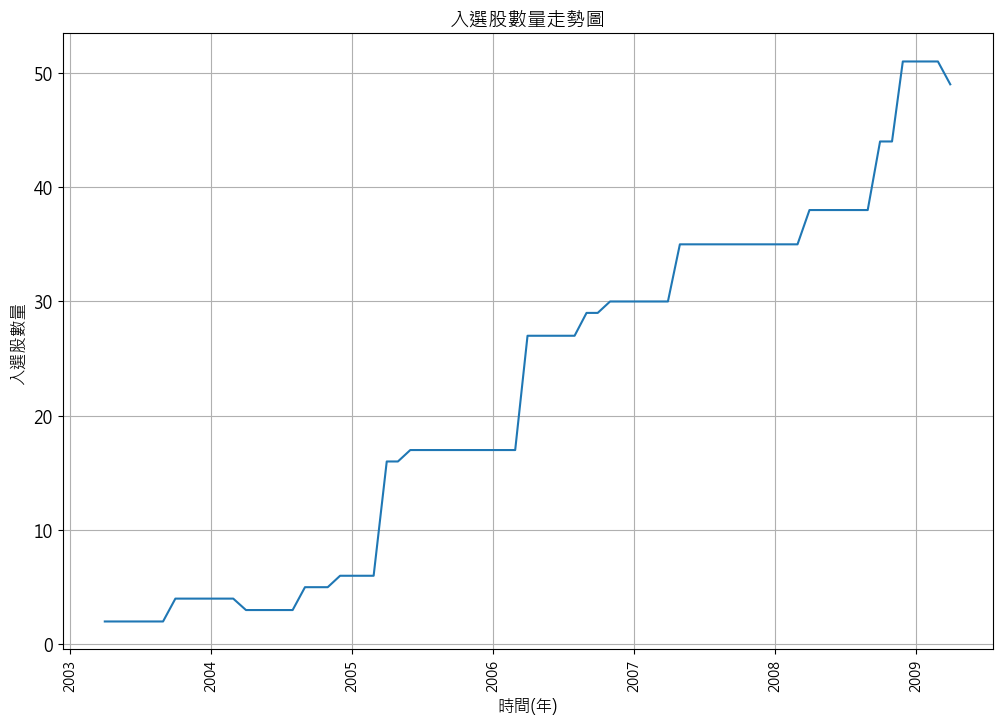

In [26]:
rep_all_cond_and_pe.plot_company_counts()

### 每月本益比進出場

In [27]:
# 每日本益比resample成每月
daily_pe_resample = daily_pe.resample('M').last()[START_DATE:END_DATE]

pe_cond_entry_daily = daily_pe_resample < 12
pe_cond_exit_daily = daily_pe_resample > 30

In [28]:
orig_all_cond_and_pe_daily = ((orig_all_cond & pe_cond_entry_daily).hold_until((~orig_all_cond) | pe_cond_exit_daily))

rep_all_cond_and_pe_daily = backtest.sim(orig_all_cond_and_pe_daily, resample='M', data=data)
rep_all_cond_and_pe_daily.display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                     11.4%  49.22      -55.18%    42.86%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
1303     2008-04-01 2009-04-01     2008-03-31    2009-03-31  0.026316     249   
1473     2003-04-01 2009-04-01     2003-03-31    2009-03-31  0.500000    1491   
1477     2005-04-01 2009-04-01     2005-03-31    2009-03-31  0.071429     991   
2002     2005-04-01 2009-04-01     2005-03-31    2009-03-31  0.071429     991   
2027     2007-05-02 2009-04-01     2007-04-30    2009-03-31  0.028571     476   
...             ...        ...            ...           ...       ...     ...   
8046     2009-04-01        NaT     2009-03-31           NaT  0.021739    3813   
8072     2009-04-01        NaT     2009-03-31           NaT  0.021739    3813   
8924     2005-04-01        NaT     2005-03-31           NaT  0.071429    4804   
9917     2008-10-01        NaT     2008-09-30           NaT  0.019608    3935   
9930     2006-04-03        NaT     2006-03-31           NaT  0.037037    4556   

          entry_index  exit_index    return       mae      gmfe      bmfe  \
stock_id                                                                    
1303             2061        2310 -0.411847 -0.522974  0.043362  0.043362   
1473              819        2310 -0.259782 -0.358219  1.018494  1.018494   
1477             1319        2310  0.145771 -0.260041  2.106229  2.106229   
2002             1319        2310  0.100460 -0.210383  1.376140  0.015704   
2027             1834        2310 -0.643627 -0.745723  0.103093  0.103093   
...               ...         ...       ...       ...       ...       ...   
8046             2310          -1  1.621605 -0.686212  9.153406  0.880004   
8072             2310          -1 -0.397489 -0.614251  0.528405  0.528405   
8924             1319          -1  2.776022 -0.601674  5.249710  0.879408   
9917             2188          -1  5.448780 -0.234411  5.945744  0.064518   
9930             1567          -1  7.618883 -0.011491  8.523685  0.000000   

               mdd   pdays    weight  next_weights  
stock_id                                            
1303     -0.542799    21.0  0.000000      0.000000  
1473     -0.682050  1315.0  0.000000      0.000000  
1477     -0.761782   838.0  0.000000      0.000000  
2002     -0.572777   757.0  0.000000      0.000000  
2027     -0.769487    42.0  0.000000      0.000000  
...            ...     ...       ...           ...  
8046     -0.833092  1725.0  0.021739      0.021739  
8072     -0.747613  1390.0  0.021739      0.021739  
8924     -0.788058  2887.0  0.021739      0.021739  
9917     -0.280811  3824.0  0.021739      0.021739  
9930     -0.467763  4551.0  0.021739      0.021739  

[65 rows x 16 columns]

In [29]:
# all_cond_pos_ret, all_cond_neg_ret = rep_all_cond_and_pe_daily.calc_returns_contrib()

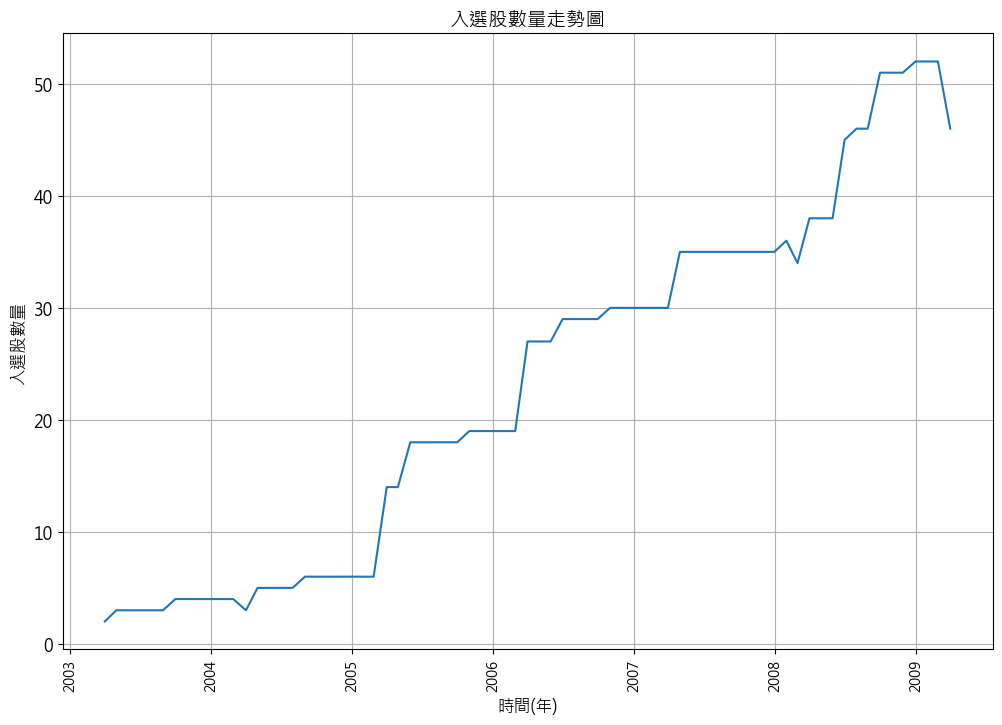

In [30]:
rep_all_cond_and_pe_daily.plot_company_counts()

---

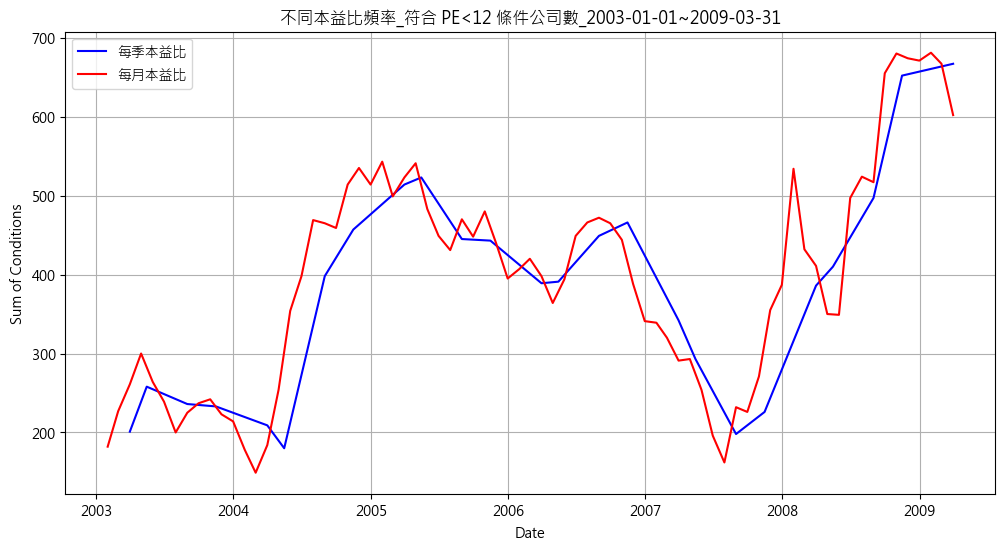

In [80]:
pe_cond_entry_sum = pe_cond_entry.sum(axis=1)
pe_cond_entry_daily_sum = pe_cond_entry_daily.sum(axis=1)

# 繪製折線圖
plt.figure(figsize=(12, 6))
plt.plot(pe_cond_entry_sum, label='每季本益比', color='blue')
plt.plot(pe_cond_entry_daily_sum, label='每月本益比', color='red')
plt.xlabel('Date')
plt.ylabel('Sum of Conditions')
plt.title(f'不同本益比頻率_符合 PE<12 條件公司數_{START_DATE}~{END_DATE}')
plt.legend()
plt.grid(True)
plt.show()

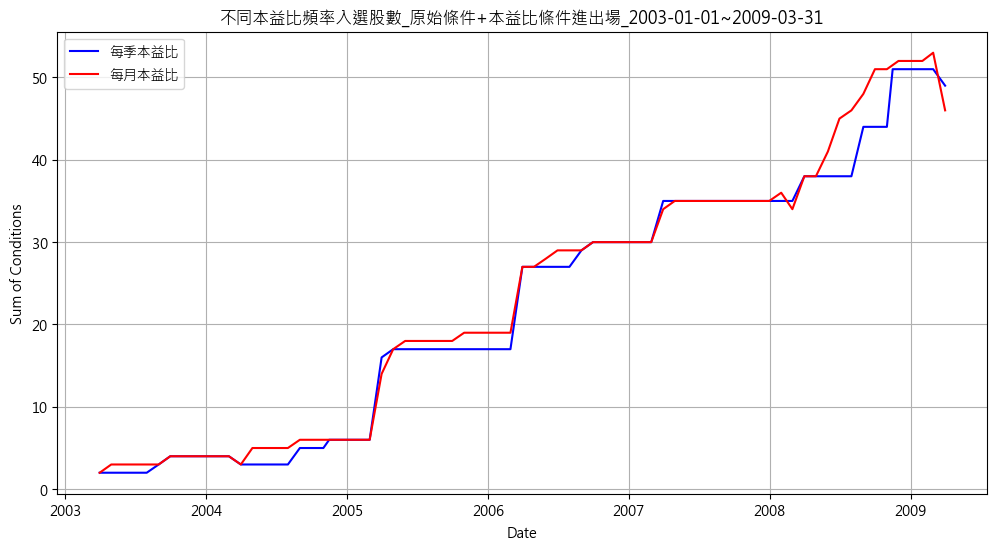

In [79]:
pe_cond_entry_sum = orig_all_cond_and_pe.sum(axis=1)
pe_cond_entry_daily_sum = orig_all_cond_and_pe_daily.sum(axis=1)

# 繪製折線圖
plt.figure(figsize=(12, 6))
plt.plot(pe_cond_entry_sum, label='每季本益比', color='blue')
plt.plot(pe_cond_entry_daily_sum, label='每月本益比', color='red')
plt.xlabel('Date')
plt.ylabel('Sum of Conditions')
plt.title(f'不同本益比頻率入選股數_原始條件+本益比條件進出場_{START_DATE}~{END_DATE}')
plt.legend()
plt.grid(True)
plt.show()

## test (省略)

In [31]:
# rep_all_cond_and_pe_daily.plot_holding_period_return()

In [32]:
# daily_pe_strat_trades = rep_all_cond_and_pe_daily.trades[['stock_id', 'entry_date', 'exit_date', 'period', 'return']].sort_values('period')

# daily_pe_strat_trades 

In [33]:
# daily_pe_strat_trades = rep_all_cond_and_pe_daily.trades[['stock_id', 'entry_date', 'exit_date', 'period', 'return', 'pdays']].sort_values('period')

In [34]:
# daily_pe_strat_trades

In [35]:
# listed[['6613']]['2019-11':'2020-04']

In [36]:
# daily_pe_strat_trades['hold_days'] = (daily_pe_strat_trades['exit_date'] - daily_pe_strat_trades['entry_date']).dt.days

In [37]:
# daily_pe_strat_trades.sort_values('pdays').head(20)

In [38]:
# close[['1537']].plot()

In [39]:
# daily_pe_strat_trades.sort_values('hold_days', inplace=True)

In [40]:
# len(daily_pe_strat_trades)

In [41]:
# len(daily_pe_strat_trades[daily_pe_strat_trades['hold_days'] < 360])

In [42]:
# # 去除還沒出場的交易 #(有些才剛進場，持有期間較短)

# # daily_pe_strat_trades = rep_all_cond_and_pe_daily.trades
# # daily_pe_strat_trades = daily_pe_strat_trades[daily_pe_strat_trades['exit_date'].notna()]

# plt.figure(figsize=(14, 6))
# # Plot points with hold_days not NaN
# plt.scatter(daily_pe_strat_trades['hold_days'][daily_pe_strat_trades['hold_days'].notna()], daily_pe_strat_trades['return'][daily_pe_strat_trades['hold_days'].notna()], alpha=0.5, s=12, label='已出場')
# # Plot points with hold_days NaN
# plt.scatter(daily_pe_strat_trades['period'][daily_pe_strat_trades['hold_days'].isna()], daily_pe_strat_trades['return'][daily_pe_strat_trades['hold_days'].isna()], alpha=0.5, s=12, marker='^', color='red', label='回測最後仍未出場')

# plt.axhline(y=0, color='red', linestyle='-', linewidth=0.5)
# plt.axvline(x=360, color='gray', linestyle='-', linewidth=0.5)

# plt.xlabel('持有天數')
# plt.xticks(range(0, 5001, 250)) 

# plt.ylabel('股價變化%')
# plt.title('台股 所有條件 + 本益比進出場')
# plt.legend()
# plt.show()


In [43]:
# # 價格比入場時高的天數

# # daily_pe_strat_trades = rep_all_cond_and_pe_daily.trades
# # daily_pe_strat_trades = daily_pe_strat_trades[daily_pe_strat_trades['exit_date'].notna()]

# plt.figure(figsize=(14, 6))
# # Plot points with hold_days not NaN
# plt.scatter(daily_pe_strat_trades['hold_days'][daily_pe_strat_trades['hold_days'].notna()], daily_pe_strat_trades['pdays'][daily_pe_strat_trades['hold_days'].notna()], alpha=0.5, s=12, label='已出場')
# # Plot points with hold_days NaN
# plt.scatter(daily_pe_strat_trades['period'][daily_pe_strat_trades['hold_days'].isna()], daily_pe_strat_trades['pdays'][daily_pe_strat_trades['hold_days'].isna()], alpha=0.5, s=12, marker='^', color='red', label='回測最後仍未出場')

# plt.axhline(y=0, color='red', linestyle='-', linewidth=0.5)
# plt.axvline(x=360, color='gray', linestyle='-', linewidth=0.5)

# plt.xlabel('持有天數')
# plt.xticks(range(0, 5001, 250)) 

# plt.ylabel('處於獲利的天數')
# plt.title('台股 所有條件 + 本益比進出場')
# plt.legend()
# plt.show()


In [44]:
# rep_all_cond_and_pe_daily.plot_periods()

In [45]:
# # 繪製柱狀圖
# plt.figure(figsize=(35, 6))
# plt.bar(df['stock_id'], df['period'])
# plt.xlabel('Stock ID')
# plt.xticks(rotation=90)
# plt.ylabel('Period (days)')
# plt.title('Period of Trades for Each Stock ID')
# plt.show()

---

## 綜合比較入選股數變化 (略)

In [46]:
# all_cond_reps = {}

# all_cond_reps['原始條件_無本益比進出場'] = orig_all_cond
# all_cond_reps['原始條件_每季本益比'] = orig_all_cond_and_pe
# all_cond_reps['原始條件_每日本益比'] = orig_all_cond_and_pe_daily


# rep_collecs = sim_conditions(all_cond_reps, resample='M', data=data)
# rep_collecs.plot_stats()

In [47]:
# rep_collecs.plot_reps_stock_counts()

---

---

## 每季本益比資料 - 比較不同resample週期

### 每月

#### 月初、月中、月底 (每季資料)

In [48]:
rep_all_cond_and_pe_MS = backtest.sim(orig_all_cond_and_pe, resample='MS', data=data)
rep_all_cond_and_pe_MS.get_stats()

{'CAGR': 0.09605126010007914,
 'daily_sharpe': 52.58,
 'max_drawdown': -0.5658340375778177,
 'avg_drawdown': -0.08995481501456593,
 'win_ratio': 0.45454545454545453,
 'ytd': 0.23882952087527332}

In [49]:
rep_all_cond_and_pe_M15 = backtest.sim(orig_all_cond_and_pe, resample='M', resample_offset='15D', data=data)
rep_all_cond_and_pe_M15.get_stats()

{'CAGR': 0.09148780024497949,
 'daily_sharpe': 52.28,
 'max_drawdown': -0.5639468685823039,
 'avg_drawdown': -0.09118161600674093,
 'win_ratio': 0.5757575757575758,
 'ytd': 0.23695217049358264}

In [50]:
rep_all_cond_and_pe_M = backtest.sim(orig_all_cond_and_pe, resample='M', data=data)
rep_all_cond_and_pe_M.get_stats()

{'CAGR': 0.09662694373369773,
 'daily_sharpe': 52.19,
 'max_drawdown': -0.5629055197171287,
 'avg_drawdown': -0.0899355318436352,
 'win_ratio': 0.5151515151515151,
 'ytd': 0.23851206173152129}

### 每季 (3, 6, 9, 12月)

In [51]:
rep_all_cond_and_pe_Q_orig = backtest.sim(orig_all_cond_and_pe, resample='Q',data=data)
rep_all_cond_and_pe_Q_orig.display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                     9.77%  51.02      -55.88%    51.52%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
1473     2003-04-01 2009-04-01     2003-03-31    2009-03-31  0.500000    1491   
1477     2005-04-01 2009-04-01     2005-03-31    2009-03-31  0.062500     991   
2002     2005-04-01 2009-04-01     2005-03-31    2009-03-31  0.062500     991   
2027     2007-07-02 2009-04-01     2007-06-29    2009-03-31  0.028571     434   
2029     2006-04-03 2009-04-01     2006-03-31    2009-03-31  0.037037     743   
...             ...        ...            ...           ...       ...     ...   
8046     2009-04-01        NaT     2009-03-31           NaT  0.020408    3813   
8072     2009-04-01        NaT     2009-03-31           NaT  0.020408    3813   
8924     2005-04-01        NaT     2005-03-31           NaT  0.062500    4804   
9917     2009-01-05        NaT     2008-12-31           NaT  0.019608    3870   
9930     2006-04-03        NaT     2006-03-31           NaT  0.037037    4556   

          entry_index  exit_index    return       mae      gmfe      bmfe  \
stock_id                                                                    
1473              819        2310 -0.259782 -0.358219  1.018494  1.018494   
1477             1319        2310  0.145771 -0.260041  2.106229  2.106229   
2002             1319        2310  0.100460 -0.210383  1.376140  0.015704   
2027             1876        2310 -0.611666 -0.723287  0.200423  0.200423   
2029             1567        2310  0.019550 -0.328110  0.530795  0.530795   
...               ...         ...       ...       ...       ...       ...   
8046             2310          -1  1.621605 -0.686212  9.153406  0.880004   
8072             2310          -1 -0.397489 -0.614251  0.528405  0.528405   
8924             1319          -1  2.776022 -0.601674  5.249710  0.879408   
9917             2253          -1  5.754051 -0.075451  6.274241  0.027025   
9930             1567          -1  7.618883 -0.011491  8.523685  0.000000   

               mdd   pdays    weight  next_weights  
stock_id                                            
1473     -0.682050  1315.0  0.000000      0.000000  
1477     -0.761782   838.0  0.000000      0.000000  
2002     -0.572777   757.0  0.000000      0.000000  
2027     -0.769487    94.0  0.000000      0.000000  
2029     -0.561084   503.0  0.000000      0.000000  
...            ...     ...       ...           ...  
8046     -0.833092  1725.0  0.020408      0.020408  
8072     -0.747613  1390.0  0.020408      0.020408  
8924     -0.788058  2887.0  0.020408      0.020408  
9917     -0.163898  3848.0  0.020408      0.020408  
9930     -0.467763  4551.0  0.020408      0.020408  

[67 rows x 16 columns]

### 每年

#### 每年三月底 + 15天、30天、45天

In [52]:
rep_all_cond_and_pe_A_MAR = backtest.sim(orig_all_cond_and_pe, resample='A-MAR', resample_offset="15D",data=data)
rep_all_cond_and_pe_A_MAR.display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                     8.77%  50.91      -55.02%     56.0%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
1473     2003-04-16 2009-04-16     2003-04-15    2009-04-15  0.500000    1491   
1477     2005-04-18 2009-04-16     2005-04-15    2009-04-15  0.062500     992   
2002     2005-04-18 2009-04-16     2005-04-15    2009-04-15  0.062500     992   
2027     2007-04-16 2009-04-16     2007-04-14    2009-04-15  0.028571     498   
2029     2006-04-17 2009-04-16     2006-04-14    2009-04-15  0.037037     745   
...             ...        ...            ...           ...       ...     ...   
8046     2009-04-16        NaT     2009-04-15           NaT  0.020408    3802   
8072     2009-04-16        NaT     2009-04-15           NaT  0.020408    3802   
8924     2005-04-18        NaT     2005-04-15           NaT  0.062500    4794   
9917     2009-04-16        NaT     2009-04-15           NaT  0.020408    3802   
9930     2006-04-17        NaT     2006-04-14           NaT  0.037037    4547   

          entry_index  exit_index    return       mae      gmfe      bmfe  \
stock_id                                                                    
1473              830        2321 -0.164205 -0.372201  0.974519  0.974519   
1477             1329        2321  0.234757 -0.250352  2.146901  2.146901   
2002             1329        2321  0.525092 -0.127009  1.627032  0.122950   
2027             1823        2321 -0.507216 -0.756983  0.054246  0.054246   
2029             1576        2321 -0.061756 -0.395624  0.376974  0.376974   
...               ...         ...       ...       ...       ...       ...   
8046             2321          -1  1.515359 -0.698900  8.742837  0.803983   
8072             2321          -1 -0.413499 -0.624402  0.488183  0.488183   
8924             1329          -1  2.794270 -0.599752  5.279866  0.888476   
9917             2321          -1  5.234061 -0.043661  5.714687  0.000000   
9930             1576          -1  7.254900 -0.016509  8.121765  0.047718   

               mdd   pdays    weight  next_weights  
stock_id                                            
1473     -0.682050  1299.0  0.000000      0.000000  
1477     -0.761782   880.0  0.000000      0.000000  
2002     -0.572777   882.0  0.000000      0.000000  
2027     -0.769487    14.0  0.000000      0.000000  
2029     -0.561084   381.0  0.000000      0.000000  
...            ...     ...       ...           ...  
8046     -0.833092  1682.0  0.020408      0.020408  
8072     -0.747613  1358.0  0.020408      0.020408  
8924     -0.788058  2887.0  0.020408      0.020408  
9917     -0.163898  3791.0  0.020408      0.020408  
9930     -0.467763  4538.0  0.020408      0.020408  

[62 rows x 16 columns]

In [53]:
rep_all_cond_and_pe_A_MAR_30D = backtest.sim(orig_all_cond_and_pe, resample='A-MAR', resample_offset="30D",data=data)
rep_all_cond_and_pe_A_MAR_30D.display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                     11.2%  49.01      -54.33%     52.0%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
1473     2003-05-02 2009-05-04     2003-04-30    2009-04-30  0.500000    1491   
1477     2005-05-03 2009-05-04     2005-04-29    2009-04-30  0.062500     993   
2002     2005-05-03 2009-05-04     2005-04-29    2009-04-30  0.062500     993   
2027     2007-05-02 2009-05-04     2007-04-30    2009-04-30  0.028571     498   
2029     2006-05-02 2009-05-04     2006-04-28    2009-04-30  0.037037     746   
...             ...        ...            ...           ...       ...     ...   
8046     2009-05-04        NaT     2009-04-30           NaT  0.020408    3791   
8072     2009-05-04        NaT     2009-04-30           NaT  0.020408    3791   
8924     2005-05-03        NaT     2005-04-29           NaT  0.062500    4784   
9917     2009-05-04        NaT     2009-04-30           NaT  0.020408    3791   
9930     2006-05-02        NaT     2006-04-28           NaT  0.037037    4537   

          entry_index  exit_index    return       mae      gmfe      bmfe  \
stock_id                                                                    
1473              841        2332 -0.097200 -0.330027  1.107163  1.107163   
1477             1339        2332  0.463580 -0.254786  2.128288  2.128288   
2002             1339        2332  0.452920 -0.131056  1.614856  0.117745   
2027             1834        2332 -0.560872 -0.745723  0.103093  0.103093   
2029             1586        2332 -0.006867 -0.334014  0.517342  0.517342   
...               ...         ...       ...       ...       ...       ...   
8046             2332          -1  1.474693 -0.703757  8.585688  0.774885   
8072             2332          -1 -0.422706 -0.630240  0.465051  0.465051   
8924             1339          -1  2.769984 -0.602310  5.239732  0.876407   
9917             2332          -1  4.711111 -0.085713  5.151947  0.005713   
9930             1586          -1  7.135329 -0.030745  7.989731  0.032552   

               mdd   pdays    weight  next_weights  
stock_id                                            
1473     -0.682050  1317.0  0.000000      0.000000  
1477     -0.761782   874.0  0.000000      0.000000  
2002     -0.572777   880.0  0.000000      0.000000  
2027     -0.769487    42.0  0.000000      0.000000  
2029     -0.561084   483.0  0.000000      0.000000  
...            ...     ...       ...           ...  
8046     -0.833092  1667.0  0.020408      0.020408  
8072     -0.747613  1308.0  0.020408      0.020408  
8924     -0.788058  2873.0  0.020408      0.020408  
9917     -0.163898  3701.0  0.020408      0.020408  
9930     -0.467763  4519.0  0.020408      0.020408  

[62 rows x 16 columns]

In [54]:
rep_all_cond_and_pe_A_MAR_45D = backtest.sim(orig_all_cond_and_pe, resample='A-MAR', resample_offset="45D",data=data)
rep_all_cond_and_pe_A_MAR_45D.display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                      9.3%  52.68      -55.21%    59.26%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
1473     2003-05-16 2009-05-18     2003-05-15    2009-05-15  0.500000    1491   
1477     2005-05-16 2009-05-18     2005-05-13    2009-05-15  0.058824     994   
2002     2005-05-16 2009-05-18     2005-05-13    2009-05-15  0.058824     994   
2027     2007-05-16 2009-05-18     2007-05-15    2009-05-15  0.028571     498   
2029     2006-05-16 2009-05-18     2006-05-15    2009-05-15  0.037037     746   
...             ...        ...            ...           ...       ...     ...   
8046     2009-05-18        NaT     2009-05-15           NaT  0.020408    3781   
8072     2009-05-18        NaT     2009-05-15           NaT  0.020408    3781   
8924     2005-05-16        NaT     2005-05-13           NaT  0.058824    4775   
9917     2009-05-18        NaT     2009-05-15           NaT  0.020408    3781   
9930     2006-05-16        NaT     2006-05-15           NaT  0.037037    4527   

          entry_index  exit_index    return       mae      gmfe          bmfe  \
stock_id                                                                        
1473              851        2342  0.010535 -0.346902  1.054090  1.054090e+00   
1477             1348        2342  0.482826 -0.253908  2.131975  2.131975e+00   
2002             1348        2342  0.543896 -0.101906  1.702575  1.552420e-01   
2027             1844        2342 -0.477449 -0.744242  0.109520  1.095196e-01   
2029             1596        2342  0.011163 -0.329301  0.528080  5.280803e-01   
...               ...         ...       ...       ...       ...           ...   
8046             2342          -1  1.312648 -0.723109  7.959491  6.589383e-01   
8072             2342          -1 -0.407832 -0.620809  0.502419  5.024191e-01   
8924             1348          -1  2.698969 -0.609790  5.122377  8.411161e-01   
9917             2342          -1  5.119452 -0.020409  5.591358  7.754722e-02   
9930             1596          -1  7.004992 -0.046262  7.845809  2.220446e-16   

               mdd   pdays    weight  next_weights  
stock_id                                            
1473     -0.682050  1306.0  0.000000      0.000000  
1477     -0.761782   882.0  0.000000      0.000000  
2002     -0.572777   935.0  0.000000      0.000000  
2027     -0.769487    38.0  0.000000      0.000000  
2029     -0.561084   495.0  0.000000      0.000000  
...            ...     ...       ...           ...  
8046     -0.833092  1610.0  0.020408      0.020408  
8072     -0.747613  1354.0  0.020408      0.020408  
8924     -0.788058  2848.0  0.020408      0.020408  
9917     -0.163898  3773.0  0.020408      0.020408  
9930     -0.467763  4477.0  0.020408      0.020408  

[61 rows x 16 columns]

---

## **每月**本益比資料 - 比較不同resample週期

In [55]:
daily_pe_entry = (daily_pe < 12)[START_DATE:END_DATE]
daily_pe_exit = (daily_pe > 30)[START_DATE:END_DATE]

### 每月

#### 月初、月中、月底

In [56]:
daily_pe_entry_MS = daily_pe_entry.resample('MS').first()
daily_pe_exit_MS = daily_pe_exit.resample('MS').first()


PE_daily_MS_cond = ((orig_all_cond & daily_pe_entry_MS).hold_until((~orig_all_cond) | daily_pe_exit_MS))
rep_PE_daily_MS_cond = backtest.sim(PE_daily_MS_cond, resample='MS', data=data)
rep_PE_daily_MS_cond.get_stats()

{'CAGR': 0.11101578299063553,
 'daily_sharpe': 49.97,
 'max_drawdown': -0.5523866944070381,
 'avg_drawdown': -0.08522522232783543,
 'win_ratio': 0.45454545454545453,
 'ytd': 0.23019855326488048}

In [57]:
rep_PE_daily_M15_cond = backtest.sim(orig_all_cond_and_pe_daily, resample='M', resample_offset='15D', data=data)
rep_PE_daily_M15_cond.display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                    10.72%  49.55      -55.78%    48.57%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
1303     2008-04-16 2009-04-16     2008-04-15    2009-04-15  0.026316     250   
1473     2003-04-16 2009-04-16     2003-04-15    2009-04-15  0.500000    1491   
1477     2005-04-18 2009-04-16     2005-04-15    2009-04-15  0.071429     992   
2002     2005-04-18 2009-04-16     2005-04-15    2009-04-15  0.071429     992   
2027     2007-05-16 2009-04-16     2007-05-15    2009-04-15  0.028571     477   
...             ...        ...            ...           ...       ...     ...   
8046     2009-04-16        NaT     2009-04-15           NaT  0.021739    3802   
8072     2009-04-16        NaT     2009-04-15           NaT  0.021739    3802   
8924     2005-04-18        NaT     2005-04-15           NaT  0.071429    4794   
9917     2008-10-16        NaT     2008-10-15           NaT  0.019608    3925   
9930     2006-04-17        NaT     2006-04-14           NaT  0.037037    4547   

          entry_index  exit_index    return       mae      gmfe      bmfe  \
stock_id                                                                    
1303             2071        2321 -0.364659 -0.535561  0.002639  0.002639   
1473              830        2321 -0.164205 -0.372201  0.974519  0.974519   
1477             1329        2321  0.234757 -0.250352  2.146901  2.146901   
2002             1329        2321  0.525092 -0.127009  1.627032  0.122950   
2027             1844        2321 -0.481073 -0.744242  0.109520  0.109520   
...               ...         ...       ...       ...       ...       ...   
8046             2321          -1  1.515359 -0.698900  8.742837  0.803983   
8072             2321          -1 -0.413499 -0.624402  0.488183  0.488183   
8924             1329          -1  2.794270 -0.599752  5.279866  0.888476   
9917             2198          -1  6.174544 -0.148327  6.726729  0.000000   
9930             1576          -1  7.254900 -0.016509  8.121765  0.047718   

               mdd   pdays    weight  next_weights  
stock_id                                            
1303     -0.536783     2.0  0.000000      0.000000  
1473     -0.682050  1299.0  0.000000      0.000000  
1477     -0.761782   880.0  0.000000      0.000000  
2002     -0.572777   882.0  0.000000      0.000000  
2027     -0.769487    38.0  0.000000      0.000000  
...            ...     ...       ...           ...  
8046     -0.833092  1682.0  0.021739      0.021739  
8072     -0.747613  1358.0  0.021739      0.021739  
8924     -0.788058  2887.0  0.021739      0.021739  
9917     -0.163898  3907.0  0.021739      0.021739  
9930     -0.467763  4538.0  0.021739      0.021739  

[65 rows x 16 columns]

### 每季

In [58]:
daily_pe_entry_Q = daily_pe_entry.resample('Q').last()
daily_pe_exit_Q = daily_pe_exit.resample('Q').last()

PE_daily_Q_cond = ((orig_all_cond & daily_pe_entry_Q).hold_until((~orig_all_cond) | daily_pe_exit_Q))
rep_PE_daily_Q_cond = backtest.sim(PE_daily_Q_cond, resample='Q', data=data)
rep_PE_daily_Q_cond.get_stats()

{'CAGR': 0.12018730046234638,
 'daily_sharpe': 46.17,
 'max_drawdown': -0.5573299542797832,
 'avg_drawdown': -0.08588732519989742,
 'win_ratio': 0.4411764705882353,
 'ytd': 0.22748323148038452}

### 每年

In [59]:
daily_pe_entry_A = daily_pe_entry.resample('A-MAR').last()
daily_pe_exit_A = daily_pe_exit.resample('A-MAR').last()

PE_daily_AMAR_cond = ((orig_all_cond & daily_pe_entry_A).hold_until((~orig_all_cond) | daily_pe_exit_A))
rep_PE_daily_AMAR15 = backtest.sim(PE_daily_AMAR_cond, resample='A-MAR', resample_offset='15D',data=data)
rep_PE_daily_AMAR15.display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                     8.33%  50.31      -56.12%    54.17%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
1303     2008-04-16 2009-04-16     2008-04-15    2009-04-15  0.026316     250   
1473     2003-04-16 2009-04-16     2003-04-15    2009-04-15  0.500000    1491   
1477     2005-04-18 2009-04-16     2005-04-15    2009-04-15  0.083333     992   
2002     2005-04-18 2009-04-16     2005-04-15    2009-04-15  0.083333     992   
2027     2008-04-16 2009-04-16     2008-04-15    2009-04-15  0.026316     250   
2029     2006-04-17 2009-04-16     2006-04-14    2009-04-15  0.041667     745   
2401     2007-04-16 2009-04-16     2007-04-14    2009-04-15  0.032258     498   
2477     2008-04-16 2009-04-16     2008-04-15    2009-04-15  0.026316     250   
3033     2007-04-16 2009-04-16     2007-04-14    2009-04-15  0.032258     498   
6277     2006-04-17 2009-04-16     2006-04-14    2009-04-15  0.041667     745   
6505     2006-04-17 2009-04-16     2006-04-14    2009-04-15  0.041667     745   
9921     2005-04-18 2009-04-16     2005-04-15    2009-04-15  0.083333     992   
9925     2008-04-16 2009-04-16     2008-04-15    2009-04-15  0.026316     250   
9927     2007-04-16 2009-04-16     2007-04-14    2009-04-15  0.032258     498   
1565     2009-04-16        NaT     2009-04-15           NaT  0.025000    3802   
1710     2006-04-17        NaT     2006-04-14           NaT  0.041667    4547   
1723     2004-04-16        NaT     2004-04-15           NaT  0.333333    5042   
2006     2009-04-16        NaT     2009-04-15           NaT  0.025000    3802   
2103     2007-04-16        NaT     2007-04-14           NaT  0.032258    4300   
2360     2009-04-16        NaT     2009-04-15           NaT  0.025000    3802   
2365     2006-04-17        NaT     2006-04-14           NaT  0.041667    4547   
2374     2008-04-16        NaT     2008-04-15           NaT  0.026316    4052   
2382     2008-04-16        NaT     2008-04-15           NaT  0.026316    4052   
2395     2009-04-16        NaT     2009-04-15           NaT  0.025000    3802   
2397     2009-04-16        NaT     2009-04-15           NaT  0.025000    3802   
2404     2005-04-18        NaT     2005-04-15           NaT  0.083333    4794   
2439     2008-04-16        NaT     2008-04-15           NaT  0.026316    4052   
2450     2009-04-16        NaT     2009-04-15           NaT  0.025000    3802   
2451     2006-04-17        NaT     2006-04-14           NaT  0.041667    4547   
2495     2007-04-16        NaT     2007-04-14           NaT  0.032258    4300   
2498     2009-04-16        NaT     2009-04-15           NaT  0.025000    3802   
2536     2009-04-16        NaT     2009-04-15           NaT  0.025000    3802   
2548     2006-04-17        NaT     2006-04-14           NaT  0.041667    4547   
2606     2005-04-18        NaT     2005-04-15           NaT  0.083333    4794   
2617     2009-04-16        NaT     2009-04-15           NaT  0.025000    3802   
3010     2007-04-16        NaT     2007-04-14           NaT  0.032258    4300   
3015     2008-04-16        NaT     2008-04-15           NaT  0.026316    4052   
3026     2009-04-16        NaT     2009-04-15           NaT  0.025000    3802   
3034     2007-04-16        NaT     2007-04-14           NaT  0.032258    4300   
3356     2009-04-16        NaT     2009-04-15           NaT  0.025000    3802   
4904     2008-04-16        NaT     2008-04-15           NaT  0.026316    4052   
5347     2008-04-16        NaT     2008-04-15           NaT  0.026316    4052   
5471     2006-04-17        NaT     2006-04-14           NaT  0.041667    4547   
5508     2007-04-16        NaT     2007-04-14           NaT  0.032258    4300   
5534     2009-04-16        NaT     2009-04-15           NaT  0.025000    3802   
6115     2009-04-16        NaT     2009-04-15           NaT  0.025000    3802   
6121     2009-04-16        NaT     2009-04-15           NaT  0.025000    3802   
6139     2006-04-17        NaT     2006-

In [60]:
rep_PE_daily_AMAR30 = backtest.sim(PE_daily_AMAR_cond, resample='A-MAR', resample_offset='30D',data=data)
rep_PE_daily_AMAR30.get_stats()

{'CAGR': 0.10257169366760688,
 'daily_sharpe': 50.16,
 'max_drawdown': -0.5534218058219171,
 'avg_drawdown': -0.09317440168665368,
 'win_ratio': 0.5,
 'ytd': 0.19528062799893342}

In [61]:
rep_PE_daily_AMAR45 = backtest.sim(PE_daily_AMAR_cond, resample='A-MAR', resample_offset='45D',data=data)
rep_PE_daily_AMAR45.get_stats()

{'CAGR': 0.09306878623881265,
 'daily_sharpe': 52.65,
 'max_drawdown': -0.5463519147046492,
 'avg_drawdown': -0.09436483104841044,
 'win_ratio': 0.625,
 'ytd': 0.1971296108753695}

### 每週、兩週

In [62]:
daily_pe_entry_W = daily_pe_entry.resample('W').last()
daily_pe_exit_W = daily_pe_exit.resample('W').last()


PE_daily_W_cond = ((orig_all_cond & daily_pe_entry_W).hold_until((~orig_all_cond) | daily_pe_exit_W))
rep_PE_daily_W = backtest.sim(PE_daily_W_cond, resample='W', data=data)
rep_PE_daily_W.get_stats()

{'CAGR': 0.12892994962230553,
 'daily_sharpe': 47.84,
 'max_drawdown': -0.5485560831260718,
 'avg_drawdown': -0.08360062436990211,
 'win_ratio': 0.45714285714285713,
 'ytd': 0.28970909103039433}

In [63]:
daily_pe_entry_2W = daily_pe_entry.resample('2W').last()
daily_pe_exit_2W = daily_pe_exit.resample('2W').last()

PE_daily_2W_cond = ((orig_all_cond & daily_pe_entry_2W).hold_until((~orig_all_cond) | daily_pe_exit_2W))
rep_PE_daily_2W = backtest.sim(PE_daily_2W_cond, resample='2W', data=data)
rep_PE_daily_2W.get_stats()

{'CAGR': 0.12679360286603347,
 'daily_sharpe': 48.81,
 'max_drawdown': -0.549134172589244,
 'avg_drawdown': -0.08417500342548294,
 'win_ratio': 0.45714285714285713,
 'ytd': 0.28853457040764985}

### 每日

In [64]:
PE_daily_D_cond = ((orig_all_cond & daily_pe_entry).hold_until((~orig_all_cond) | daily_pe_exit))
rep_PE_daily_D = backtest.sim(PE_daily_D_cond, resample='D', data=data)
rep_PE_daily_D.display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                    12.26%  48.15      -54.55%    44.44%

entry_date  exit_date entry_sig_date exit_sig_date  position  period  \
stock_id                                                                        
1473     2003-04-01 2009-04-01     2003-03-31    2009-03-31  0.500000    1491   
1477     2005-04-01 2009-04-01     2005-03-31    2009-03-31  0.071429     991   
2002     2005-04-01 2009-04-01     2005-03-31    2009-03-31  0.071429     991   
2027     2007-05-02 2009-04-01     2007-04-30    2009-03-31  0.028571     476   
2029     2006-04-03 2009-04-01     2006-03-31    2009-03-31  0.037037     743   
...             ...        ...            ...           ...       ...     ...   
8046     2009-04-01        NaT     2009-03-31           NaT  0.021739    3813   
8072     2009-04-01        NaT     2009-03-31           NaT  0.021739    3813   
8924     2005-04-01        NaT     2005-03-31           NaT  0.071429    4804   
9917     2008-07-21        NaT     2008-07-18           NaT  0.020000    3985   
9930     2006-04-03        NaT     2006-03-31           NaT  0.037037    4556   

          entry_index  exit_index    return       mae      gmfe      bmfe  \
stock_id                                                                    
1473              819        2310 -0.259782 -0.358219  1.018494  1.018494   
1477             1319        2310  0.145771 -0.260041  2.106229  2.106229   
2002             1319        2310  0.100460 -0.210383  1.376140  0.015704   
2027             1834        2310 -0.643627 -0.745723  0.103093  0.103093   
2029             1567        2310  0.019550 -0.328110  0.530795  0.530795   
...               ...         ...       ...       ...       ...       ...   
8046             2310          -1  1.621605 -0.686212  9.153406  0.880004   
8072             2310          -1 -0.397489 -0.614251  0.528405  0.528405   
8924             1319          -1  2.776022 -0.601674  5.249710  0.879408   
9917             2138          -1  4.937533 -0.295050  5.395597  0.089112   
9930             1567          -1  7.618883 -0.011491  8.523685  0.000000   

               mdd   pdays    weight  next_weights  
stock_id                                            
1473     -0.682050  1315.0  0.000000      0.000000  
1477     -0.761782   838.0  0.000000      0.000000  
2002     -0.572777   757.0  0.000000      0.000000  
2027     -0.769487    42.0  0.000000      0.000000  
2029     -0.561084   503.0  0.000000      0.000000  
...            ...     ...       ...           ...  
8046     -0.833092  1725.0  0.021739      0.021739  
8072     -0.747613  1390.0  0.021739      0.021739  
8924     -0.788058  2887.0  0.021739      0.021739  
9917     -0.352730  3798.0  0.021739      0.021739  
9930     -0.467763  4551.0  0.021739      0.021739  

[63 rows x 16 columns]

---

---

In [65]:
# plt.figure(figsize=(18, 6))
# plt.plot(pe[START_DATE:].resample('M').last().ffill().sum(axis=1), label='PE', color='blue')
# plt.plot(daily_pe[START_DATE:].resample('M').last().ffill().sum(axis=1), label='Daily PE', color='red')
# plt.legend()
# plt.show()

In [66]:
# len(rep_all_cond_and_pe.cashflow.columns[:-1].to_list())

In [67]:
# len(rep_all_cond_and_pe_daily.cashflow.columns[:-1].to_list())

In [68]:
# list1 = rep_all_cond_and_pe.cashflow.columns[:-1].to_list() # 每季本益比
# list2 = rep_all_cond_and_pe_daily.cashflow.columns[:-1].to_list() # 每日本益比


# unique_in_list1 = set(list1) - set(list2)
# unique_in_list2 = set(list2) - set(list1)


# unique_in_list1_list = list(unique_in_list1)
# unique_in_list2_list = list(unique_in_list2)

# print("只存在於list1中的元素:", unique_in_list1_list)
# print("只存在於list2中的元素:", unique_in_list2_list)

In [69]:
# quarter_pe_selected = pe.loc[:, list1][START_DATE:].resample('M').last().ffill().sum(axis=1)
# daily_pe_selected = daily_pe.loc[:, list2][START_DATE:].resample('M').last().ffill().sum(axis=1)

In [70]:
# plt.figure(figsize=(18, 6))
# plt.plot(quarter_pe_selected, label='PE', color='blue')
# plt.plot(daily_pe_selected, label='Daily PE', color='red')
# plt.legend()
# plt.show()